In [1]:
# import osmnx as ox
import pandas as pd
import geopandas as gpd
import json
from io import StringIO
import warnings
import sys
import os
warnings.filterwarnings("ignore")
sys.stderr = open(os.devnull, 'w')


## Версия 1 

In [2]:
region = gpd.read_file('9 регионов/Волгоградская область/Каркас населения/region.geojson')
region

,osm_id,name,layer,2019,2020,2021,2022,2023,admin_level,key,admin_center,status,geometry
0,-77665.0,Волгоградская область,Волгоградская область,2507509.0,2491036.0,2474556.0,2449781.0,2470057.0,4,18000000000,,область,"MULTIPOLYGON (((41.16810 50.77451, 41.17850 50..."


In [9]:
district = gpd.read_file('C:\Code\PopFrame\examples\data/territories\shlis.geojson')

In [4]:
settlement = gpd.read_file('9 регионов/Волгоградская область/Каркас населения/settlement.geojson')
settlement

,osm_id,name,layer,2019,2020,2021,2022,2023,admin_level,key,admin_center,status,geometry
0,NaN,Революционное,Палласовский район,1238.0,1218.0,1215.0,1206.0,1056.0,8,None,None,сельское поселение,"MULTIPOLYGON (((46.78903 49.63836, 46.73639 49..."
1,-1446299.0,Стеженское,Алексеевский район,685.0,675.0,694.0,675.0,630.0,8,None,None,сельское поселение,"MULTIPOLYGON (((41.97687 50.29195, 41.97739 50..."
2,-1443108.0,Краснооктябрьское,Алексеевский район,769.0,748.0,725.0,668.0,929.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.36857 50.28091, 42.36860 50..."
3,-1443107.0,Ларинское,Алексеевский район,714.0,713.0,700.0,694.0,663.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.21293 50.28499, 42.21300 50..."
4,-1443106.0,Яминское,Алексеевский район,1417.0,1399.0,1384.0,1376.0,1393.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.19721 50.32547, 42.20512 50..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,-1676128.0,Красноярское,Чернышковский район,1124.0,1110.0,1105.0,1105.0,984.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.27296 48.40632, 42.27870 48..."
430,-1676127.0,Большетерновское,Чернышковский район,795.0,777.0,745.0,722.0,750.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.29665 48.45521, 42.32227 48..."
431,-1676000.0,Пристеновское,Чернышковский район,467.0,455.0,442.0,435.0,497.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.72587 48.28015, 42.72692 48..."
432,-1675999.0,Алешкинское,Чернышковский район,380.0,375.0,364.0,349.0,370.0,8,None,None,сельское поселение,"MULTIPOLYGON (((42.48190 48.22617, 42.49394 48..."


In [8]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from retrying import retry
from matplotlib.lines import Line2D
import contextily as ctx

@retry(stop_max_attempt_number=5, wait_fixed=2000)
def fetch_osm_data(polygon, tags):
    return ox.geometries_from_polygon(polygon, tags=tags)

def get_landuse_data(polygon):
    print(f"Polygon bounds: {polygon.bounds}")
    
    # Определение тегов для каждого показателя
    landuse_tags = {
        '1.3.1 Процент застройки жилищным строительством': ['residential', 'apartments', 'detached', 'construction'],
        '1.3.2 Процент земель сельскохозяйственного назначения': ['farmland', 'farmyard', 'orchard', 'vineyard', 'greenhouse_horticulture', 'meadow', 'plant_nursery', 'aquaculture', 'animal_keeping', 'breeding'],
        '1.3.3 Процент земель промышленного назначения': ['industrial', 'quarry', 'landfill'],
        '1.3.4 Процент земель, занимаемыми лесными массивами': ['forest'],
        '1.3.5 Процент земель специального назначения': ['military', 'railway', 'cemetery', 'landfill', 'brownfield'],
        '1.3.6 Процент земель населенных пунктов': ['place_city'],
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': ['national_park', 'protected_area', 'nature_reserve', 'conservation'],
        '1.3.8 Процент земель, занимаемых водным фондом': ['basin', 'reservoir', 'water', 'salt_pond']
    }
    
    # Собираем все уникальные теги
    unique_tags = set(tag for tags in landuse_tags.values() for tag in tags)
    tag_filters = [{'landuse': tag} for tag in unique_tags if not tag.startswith('boundary_') and not tag.startswith('place_')] + \
                  [{'boundary': 'administrative'}] + \
                  [{'place': 'city'}]
    
    # Параллельная загрузка данных по уникальным тегам
    unique_gdfs = {}
    with ThreadPoolExecutor() as executor:
        future_to_tag_filter = {executor.submit(fetch_osm_data, polygon, tag_filter): tag_filter for tag_filter in tag_filters}
        for future in as_completed(future_to_tag_filter):
            tag_filter = future_to_tag_filter[future]
            try:
                gdf = future.result()
                if not gdf.empty:
                    gdf = gdf.set_geometry('geometry')
                    if gdf.crs is None:
                        gdf.set_crs(epsg=4326, inplace=True)  # Установить исходный CRS как WGS84 (EPSG:4326)
                    unique_gdfs[frozenset(tag_filter.items())] = gdf
            except Exception as e:
                print(f"Error fetching data for tag filter {tag_filter}: {e}")

    # Распределение данных по категориям
    landuse_gdfs = {}
    for category, tags in landuse_tags.items():
        category_gdf = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry')
        for tag in tags:
            if tag.startswith('boundary_'):
                tag_filter = {'boundary': 'administrative'}
            elif tag.startswith('place_'):
                tag_filter = {'place': 'city'}
            else:
                tag_filter = {'landuse': tag} if tag not in ['wood', 'water'] else {'natural': tag}
            
            gdf = unique_gdfs.get(frozenset(tag_filter.items()))
            if gdf is not None:
                category_gdf = category_gdf.append(gdf, ignore_index=True)
        landuse_gdfs[category] = category_gdf
        print(f"Number of geometries fetched for {category}: {len(landuse_gdfs[category])}")
    
    return landuse_gdfs

def calculate_urbanization(region_gdf, landuse_gdfs_list):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    region_gdf = region_gdf.dropna(subset=['geometry'])  # Удаление строк с NaN в геометрии
    region_gdf = region_gdf[~region_gdf.is_empty]  # Удаление пустых геометрий
    
    if region_gdf.empty:
        raise ValueError("Region GeoDataFrame is empty after cleaning.")

    crs = region_gdf.estimate_utm_crs()
    region_gdf_utm = region_gdf.to_crs(crs)  # Преобразование региона в UTM
    region_area_km2 = region_gdf_utm.geometry.area.sum() / 1e6  # Площадь региона в квадратных километрах
    
    total_landuse_areas_km2 = {key: 0 for key in landuse_gdfs_list[0].keys()}

    for landuse_gdfs in landuse_gdfs_list:
        for key, gdf in landuse_gdfs.items():
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            gdf = gdf.dropna(subset=['geometry'])  # Удаление строк с NaN в геометрии
            gdf = gdf[~gdf.is_empty]  # Удаление пустых геометрий
            
            # Удаление строк с NaN в координатах геометрий
            gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom if geom is not None and not geom.is_empty else None)
            gdf = gdf.dropna(subset=['geometry'])
            
            if gdf.empty:
                continue

            crs = gdf.estimate_utm_crs()
            gdf_utm = gdf.to_crs(crs)  # Преобразование каждого типа земельного использования в UTM
            
            # Разделение на типы геометрий
            for geom_type in [Polygon, MultiPolygon, Point, LineString]:
                gdf_geom_type = gdf_utm[gdf_utm.geometry.type == geom_type.__name__]
                if not gdf_geom_type.empty:
                    # Пересечение с регионом
                    gdf_utm_intersect = gpd.overlay(gdf_geom_type, region_gdf_utm, how='intersection')
                    landuse_area_km2 = gdf_utm_intersect.geometry.area.sum() / 1e6  # Площадь в квадратных километрах
                    total_landuse_areas_km2[key] += landuse_area_km2

    urbanization_data = {key: round((area / region_area_km2) * 100, 1) for key, area in total_landuse_areas_km2.items()}
    
    return urbanization_data



def plot_landuse(region_gdf, landuse_gdfs):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    crs = region_gdf.estimate_utm_crs()
    region_gdf_utm = region_gdf.to_crs(crs)  # Преобразование региона в UTM

    fig, ax = plt.subplots(figsize=(10, 10))  # Увеличим размер фигуры
    ax.set_axis_off()  # Отключение осей
    
    region_gdf_utm.boundary.plot(ax=ax, linewidth=1, color='black', label='Граница региона')

    colors = {
        'Застройка жилищным строительством': 'blue',
        'Сельскохозяйственные земли': 'yellow',
        'Промышленные земли': 'gray',
        'Лесные массивы': 'green',
        'Земли специального назначения': 'brown',
        'Земли населенных пунктов': 'orange',
        'Особо охраняемые природные территории': 'purple',
        'Водный фонд': 'cyan'
    }
    
    landuse_mapping = {
        '1.3.1 Процент застройки жилищным строительством': 'Застройка жилищным строительством',
        '1.3.2 Процент земель сельскохозяйственного назначения': 'Сельскохозяйственные земли',
        '1.3.3 Процент земель промышленного назначения': 'Промышленные земли',
        '1.3.4 Процент земель, занимаемыми лесными массивами': 'Лесные массивы',
        '1.3.5 Процент земель специального назначения': 'Земли специального назначения',
        '1.3.6 Процент земель населенных пунктов': 'Земли населенных пунктов',
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': 'Особо охраняемые природные территории',
        '1.3.8 Процент земель, занимаемых водным фондом': 'Водный фонд'
    }
    
    for key, gdf in landuse_gdfs.items():
        if not gdf.empty:
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            crs = gdf.estimate_utm_crs()
            gdf_utm = gdf.to_crs(crs)  # Преобразование каждого типа земельного использования в UTM
            label = landuse_mapping.get(key, key)
            gdf_utm.plot(ax=ax, color=colors.get(label, 'gray'), alpha=0.5, label=label)
    
    # Добавление подложки карты
    ctx.add_basemap(ax, crs=crs, source=ctx.providers.CartoDB.Positron)

    # Создание пользовательских меток для легенды
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=10) 
                       for label, color in colors.items()]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))  # Перемещение легенды в верхнюю часть справа
    plt.show()


In [23]:
district = gpd.read_file('C:\Code\PopFrame\9 регионов\Волгоградская область\Каркас населения\district.geojson')
gdf_region = district.loc[[32]].reset_index(drop=True)

# gdf_region = district.iloc[:1]
# gdf_region = district
gdf_region_utm = gdf_region

# Проверка CRS
print(gdf_region_utm.crs)

# Вычисление площади в квадратных метрах и преобразование в квадратные километры
gdf_region_utm['area_km2'] = gdf_region_utm.geometry.area / 1e6  # 1 км² = 1,000,000 м²

# Суммарная площадь региона в квадратных километрах
region_area_km2 = gdf_region_utm['area_km2'].sum()
print(f"Region area in square kilometers: {region_area_km2}")

EPSG:4326
Region area in square kilometers: 1.0741837093770464e-07


In [24]:
landuse_gdfs_list = []

for idx, district in gdf_region_utm.iterrows():
    polygon = district.geometry
    landuse_gdfs = get_landuse_data(polygon)
    landuse_gdfs_list.append(landuse_gdfs)

# Расчет степени урбанизации для всего региона
urbanization_data = calculate_urbanization(gdf_region, landuse_gdfs_list)

total_percentage = sum(urbanization_data.values())
print(f"Total percentage: {total_percentage}")


Polygon bounds: (44.1087686, 48.4070531, 44.6874279, 48.8890717)
Error fetching data for tag filter {'landuse': 'water'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'protected_area'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'breeding'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'detached'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'railway'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'conservation'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'salt_pond'}: No data elements in server response. Check log and query location/tags.
Erro

In [36]:
urbanization_data

{'1.3.1 Процент застройки жилищным строительством': 10.1,
 '1.3.2 Процент земель сельскохозяйственного назначения': 17.2,
 '1.3.3 Процент земель промышленного назначения': 5.4,
 '1.3.4 Процент земель, занимаемыми лесными массивами': 0.2,
 '1.3.5 Процент земель специального назначения': 1.3,
 '1.3.6 Процент земель населенных пунктов': 98.3,
 '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': 0.0,
 '1.3.8 Процент земель, занимаемых водным фондом': 0.0}

In [22]:
plot_landuse(gdf_region, landuse_gdfs)

NameError: name 'plot_landuse' is not defined

In [39]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from retrying import retry
from matplotlib.lines import Line2D
import contextily as ctx
import pandas as pd

@retry(stop_max_attempt_number=5, wait_fixed=2000)
def fetch_osm_data(polygon, tags):
    return ox.geometries_from_polygon(polygon, tags=tags)

def get_landuse_data(polygon):
    print(f"Polygon bounds: {polygon.bounds}")
    
    # Определение тегов для каждого показателя
    landuse_tags = {
        '1.3.1 Процент застройки жилищным строительством': ['residential', 'apartments', 'detached', 'construction'],
        '1.3.2 Процент земель сельскохозяйственного назначения': ['farmland', 'farmyard', 'orchard', 'vineyard', 'greenhouse_horticulture', 'meadow', 'plant_nursery', 'aquaculture', 'animal_keeping', 'breeding'],
        '1.3.3 Процент земель промышленного назначения': ['industrial', 'quarry', 'landfill'],
        '1.3.4 Процент земель, занимаемыми лесными массивами': ['forest'],
        '1.3.5 Процент земель специального назначения': ['military', 'railway', 'cemetery', 'landfill', 'brownfield'],
        '1.3.6 Процент земель населенных пунктов': ['place_city'],
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': ['national_park', 'protected_area', 'nature_reserve', 'conservation'],
        '1.3.8 Процент земель, занимаемых водным фондом': ['basin', 'reservoir', 'water', 'salt_pond']
    }
    
    # Собираем все уникальные теги
    unique_tags = set(tag for tags in landuse_tags.values() for tag in tags)
    tag_filters = [{'landuse': tag} for tag in unique_tags if not tag.startswith('boundary_') and not tag.startswith('place_')] + \
                  [{'boundary': 'administrative'}] + \
                  [{'place': 'city'}]
    
    # Параллельная загрузка данных по уникальным тегам
    unique_gdfs = {}
    with ThreadPoolExecutor() as executor:
        future_to_tag_filter = {executor.submit(fetch_osm_data, polygon, tag_filter): tag_filter for tag_filter in tag_filters}
        for future in as_completed(future_to_tag_filter):
            tag_filter = future_to_tag_filter[future]
            try:
                gdf = future.result()
                if not gdf.empty:
                    gdf = gdf.set_geometry('geometry')
                    if gdf.crs is None:
                        gdf.set_crs(epsg=4326, inplace=True)  # Установить исходный CRS как WGS84 (EPSG:4326)
                    unique_gdfs[frozenset(tag_filter.items())] = gdf
            except Exception as e:
                print(f"Error fetching data for tag filter {tag_filter}: {e}")

    # Распределение данных по категориям
    landuse_gdfs = {}
    for category, tags in landuse_tags.items():
        category_gdf = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry')
        for tag in tags:
            if tag.startswith('boundary_'):
                tag_filter = {'boundary': 'administrative'}
            elif tag.startswith('place_'):
                tag_filter = {'place': 'city'}
            else:
                tag_filter = {'landuse': tag} if tag not in ['wood', 'water'] else {'natural': tag}
            
            gdf = unique_gdfs.get(frozenset(tag_filter.items()))
            if gdf is not None:
                category_gdf = category_gdf.append(gdf, ignore_index=True)
        landuse_gdfs[category] = category_gdf
        print(f"Number of geometries fetched for {category}: {len(landuse_gdfs[category])}")
    
    return landuse_gdfs

def calculate_urbanization(region_gdf, landuse_gdfs_list):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    region_gdf = region_gdf.dropna(subset=['geometry'])
    region_gdf = region_gdf[~region_gdf.is_empty]
    
    if region_gdf.empty:
        raise ValueError("Region GeoDataFrame is empty after cleaning.")

    crs = region_gdf.estimate_utm_crs()
    region_gdf_utm = region_gdf.to_crs(crs)
    region_area_km2 = region_gdf_utm.geometry.area.sum() / 1e6
    
    total_landuse_areas_km2 = {key: 0 for key in landuse_gdfs_list[0].keys()}

    for landuse_gdfs in landuse_gdfs_list:
        for key, gdf in landuse_gdfs.items():
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            gdf = gdf.dropna(subset=['geometry'])
            gdf = gdf[~gdf.is_empty]
            
            gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom if geom is not None and not geom.is_empty else None)
            gdf = gdf.dropna(subset=['geometry'])
            
            if gdf.empty:
                continue

            crs = gdf.estimate_utm_crs()
            gdf_utm = gdf.to_crs(crs)
            
            for geom_type in [Polygon, MultiPolygon, Point, LineString]:
                gdf_geom_type = gdf_utm[gdf_utm.geometry.type == geom_type.__name__]
                if not gdf_geom_type.empty:
                    gdf_utm_intersect = gpd.overlay(gdf_geom_type, region_gdf_utm, how='intersection')
                    landuse_area_km2 = gdf_utm_intersect.geometry.area.sum() / 1e6
                    total_landuse_areas_km2[key] += landuse_area_km2

    urbanization_data = {key: round((area / region_area_km2) * 100, 1) for key, area in total_landuse_areas_km2.items()}
    
    return urbanization_data

def process_districts(districts_gdf):
    results = []
    for idx, district in districts_gdf.iterrows():
        district_gdf = gpd.GeoDataFrame([district], columns=districts_gdf.columns)
        landuse_data = get_landuse_data(district_gdf.geometry.iloc[0])
        urbanization_data = calculate_urbanization(district_gdf, [landuse_data])
        
        total_percentage = sum(urbanization_data.values())
        urbanization_data['1.3 Степень урбанизации территории'] = total_percentage
        
        for key, value in urbanization_data.items():
            results.append({
                '№ п/п': key.split(' ')[0],
                'Название хранимое': ' '.join(key.split(' ')[1:]) if ' ' in key else key,  # Удаление первой части и оставление только текста
                'ед.изм.': '%',
                'Значение': value,
                'Территория': district['name'],  # Assuming there's a 'name' column for district names
                'Источник': 'modeled',
                'Период': 2024
            })
    
    results_gdf = pd.DataFrame(results)
    return gpd.GeoDataFrame(results_gdf)

# Пример использования:
# districts_gdf = gpd.read_file('C:\Code\PopFrame\9 регионов\Волгоградская область\Каркас населения\district.geojson')
# # districts_gdf = districts_gdf.iloc[:2]
districts_gdf = gpd.read_file('C:\Code\PopFrame\9 регионов\Волгоградская область\Каркас населения\district.geojson')
districts_gdf = district.loc[[32]].reset_index(drop=True)
result_gdf = process_districts(districts_gdf)
result_gdf

Polygon bounds: (44.1087686, 48.4070531, 44.6874279, 48.8890717)
Error fetching data for tag filter {'landuse': 'national_park'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'protected_area'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'breeding'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'detached'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'railway'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'salt_pond'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'water'}: No data elements in server response. Check log and query location/tags.
Err

,№ п/п,Название хранимое,ед.изм.,Значение,Территория,Источник,Период
0,1.3.1,Процент застройки жилищным строительством,%,10.1,Волгоград,modeled,2024
1,1.3.2,Процент земель сельскохозяйственного назначения,%,17.2,Волгоград,modeled,2024
2,1.3.3,Процент земель промышленного назначения,%,5.4,Волгоград,modeled,2024
3,1.3.4,"Процент земель, занимаемыми лесными массивами",%,0.2,Волгоград,modeled,2024
4,1.3.5,Процент земель специального назначения,%,1.3,Волгоград,modeled,2024
5,1.3.6,Процент земель населенных пунктов,%,98.3,Волгоград,modeled,2024
6,1.3.7,"Процент земель, занимаемых особо охраняемыми п...",%,0.0,Волгоград,modeled,2024
7,1.3.8,"Процент земель, занимаемых водным фондом",%,0.0,Волгоград,modeled,2024
8,1.3,Степень урбанизации территории,%,132.5,Волгоград,modeled,2024


## Версия 2

In [2]:
def plot_landuse(region_gdf, landuse_gdfs):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    crs = region_gdf.estimate_utm_crs()
    region_gdf_utm = region_gdf.to_crs(crs)  # Преобразование региона в UTM

    fig, ax = plt.subplots(figsize=(10, 10))  # Увеличим размер фигуры
    ax.set_axis_off()  # Отключение осей
    
    region_gdf_utm.boundary.plot(ax=ax, linewidth=1, color='black', label='Граница региона')

    colors = {
        'Застройка жилищным строительством': 'blue',
        'Сельскохозяйственные земли': 'yellow',
        'Промышленные земли': 'gray',
        'Лесные массивы': 'green',
        'Земли специального назначения': 'brown',
        'Земли населенных пунктов': 'orange',
        'Особо охраняемые природные территории': 'purple',
        'Водный фонд': 'cyan'
    }
    
    landuse_mapping = {
        '1.3.1 Процент застройки жилищным строительством': 'Застройка жилищным строительством',
        '1.3.2 Процент земель сельскохозяйственного назначения': 'Сельскохозяйственные земли',
        '1.3.3 Процент земель промышленного назначения': 'Промышленные земли',
        '1.3.4 Процент земель, занимаемыми лесными массивами': 'Лесные массивы',
        '1.3.5 Процент земель специального назначения': 'Земли специального назначения',
        '1.3.6 Процент земель населенных пунктов': 'Земли населенных пунктов',
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': 'Особо охраняемые природные территории',
        '1.3.8 Процент земель, занимаемых водным фондом': 'Водный фонд'
    }
    
    for key, gdf in landuse_gdfs.items():
        if not gdf.empty:
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            crs = gdf.estimate_utm_crs()
            gdf_utm = gdf.to_crs(crs)  # Преобразование каждого типа земельного использования в UTM
            label = landuse_mapping.get(key, key)
            gdf_utm.plot(ax=ax, color=colors.get(label, 'gray'), alpha=0.5, label=label)
    
    # Добавление подложки карты
    ctx.add_basemap(ax, crs=crs, source=ctx.providers.CartoDB.Positron)

    # Создание пользовательских меток для легенды
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=10) 
                       for label, color in colors.items()]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))  # Перемещение легенды в верхнюю часть справа
    plt.show()

In [3]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, GeometryCollection
from shapely.ops import unary_union
from concurrent.futures import ThreadPoolExecutor, as_completed
from retrying import retry
import pandas as pd

@retry(stop_max_attempt_number=5, wait_fixed=2000)
def fetch_osm_data(polygon, tags):
    return ox.geometries_from_polygon(polygon, tags=tags)

def get_landuse_data(polygon):
    print(f"Polygon bounds: {polygon.bounds}")
    
    landuse_tags = {
        '1.3.1 Процент застройки жилищным строительством': ['residential', 'apartments', 'detached', 'construction'],
        '1.3.2 Процент земель сельскохозяйственного назначения': ['farmland', 'farmyard', 'orchard', 'vineyard', 'greenhouse_horticulture', 'meadow', 'plant_nursery', 'aquaculture', 'animal_keeping', 'breeding'],
        '1.3.3 Процент земель промышленного назначения': ['industrial', 'quarry', 'landfill'],
        '1.3.4 Процент земель, занимаемыми лесными массивами': ['forest'],
        '1.3.5 Процент земель специального назначения': ['military', 'railway', 'cemetery', 'landfill', 'brownfield'],
        '1.3.6 Процент земель населенных пунктов': ['place_city', 'place_town'],
        '1.3.7 Процент земель, занимаемых особо охраняемыми природными территориями': ['national_park', 'protected_area', 'nature_reserve', 'conservation'],
        '1.3.8 Процент земель, занимаемых водным фондом': ['basin', 'reservoir', 'water', 'salt_pond']
    }

    # Собираем все уникальные теги
    unique_tags = set(tag for tags in landuse_tags.values() for tag in tags)
    tag_filters = [{'landuse': tag} for tag in unique_tags if not tag.startswith('place_')] + \
                  [{'place': 'city'}, {'place': 'town'}]
    
    # Параллельная загрузка данных по уникальным тегам
    unique_gdfs = {}
    with ThreadPoolExecutor() as executor:
        future_to_tag_filter = {executor.submit(fetch_osm_data, polygon, tag_filter): tag_filter for tag_filter in tag_filters}
        for future in as_completed(future_to_tag_filter):
            tag_filter = future_to_tag_filter[future]
            try:
                gdf = future.result()
                if not gdf.empty:
                    gdf = gdf.set_geometry('geometry')
                    if gdf.crs is None:
                        gdf.set_crs(epsg=4326, inplace=True)  # Установить исходный CRS как WGS84 (EPSG:4326)
                    unique_gdfs[frozenset(tag_filter.items())] = gdf
            except Exception as e:
                print(f"Error fetching data for tag filter {tag_filter}: {e}")

    # Распределение данных по категориям
    landuse_gdfs = {}
    for category, tags in landuse_tags.items():
        category_geoms = []
        for tag in tags:
            if tag.startswith('place_'):
                tag_filter = {'place': 'city' if tag == 'place_city' else 'town'}
            else:
                tag_filter = {'landuse': tag} if tag not in ['wood', 'water'] else {'natural': tag}
            
            gdf = unique_gdfs.get(frozenset(tag_filter.items()))
            if gdf is not None:
                category_geoms.extend(gdf.geometry)
        
        if category_geoms:
            category_union = unary_union(category_geoms)
            category_intersect = category_union.intersection(polygon)
            if isinstance(category_intersect, (Polygon, MultiPolygon)):
                category_gdf = gpd.GeoDataFrame(geometry=[category_intersect], crs='EPSG:4326')
            elif isinstance(category_intersect, GeometryCollection):
                category_gdf = gpd.GeoDataFrame(geometry=[geom for geom in category_intersect.geoms if isinstance(geom, (Polygon, MultiPolygon))], crs='EPSG:4326')
            else:
                category_gdf = gpd.GeoDataFrame(geometry=[], crs='EPSG:4326')
            landuse_gdfs[category] = category_gdf
        else:
            landuse_gdfs[category] = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry')

        print(f"Number of geometries fetched for {category}: {len(landuse_gdfs[category])}")
    
    return landuse_gdfs

def calculate_urbanization(region_gdf, landuse_gdfs_list):
    if region_gdf.crs is None:
        region_gdf.set_crs(epsg=4326, inplace=True)
    region_gdf = region_gdf.dropna(subset=['geometry'])
    region_gdf = region_gdf[~region_gdf.is_empty]
    
    if region_gdf.empty:
        raise ValueError("Region GeoDataFrame is empty after cleaning.")

    crs = region_gdf.estimate_utm_crs()
    region_gdf_utm = region_gdf.to_crs(crs)
    region_area_km2 = region_gdf_utm.geometry.area.sum() / 1e6
    
    total_landuse_areas_km2 = {key: 0 for key in landuse_gdfs_list[0].keys()}

    # Объединение всех полигонов для расчета степени урбанизации
    all_landuse_geoms = []
    
    for landuse_gdfs in landuse_gdfs_list:
        for key, gdf in landuse_gdfs.items():
            if gdf.crs is None:
                gdf.set_crs(epsg=4326, inplace=True)
            gdf = gdf.dropna(subset=['geometry'])
            gdf = gdf[~gdf.is_empty]
            
            gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom if geom is not None and not geom.is_empty else None)
            gdf = gdf.dropna(subset=['geometry'])
            
            if gdf.empty:
                continue

            crs = gdf.estimate_utm_crs()
            gdf_utm = gdf.to_crs(crs)
            
            all_landuse_geoms.extend(gdf_utm.geometry)
            
            if key != '1.3 Степень урбанизации территории':
                for geom_type in [Polygon, MultiPolygon, Point, LineString]:
                    gdf_geom_type = gdf_utm[gdf_utm.geometry.type == geom_type.__name__]
                    if not gdf_geom_type.empty:
                        gdf_utm_intersect = gpd.overlay(gdf_geom_type, region_gdf_utm, how='intersection')
                        landuse_area_km2 = gdf_utm_intersect.geometry.area.sum() / 1e6
                        total_landuse_areas_km2[key] += landuse_area_km2
    
    # Обработка GeometryCollection
    all_landuse_union = unary_union(all_landuse_geoms)
    if isinstance(all_landuse_union, GeometryCollection):
        all_landuse_union = [geom for geom in all_landuse_union.geoms if isinstance(geom, (Polygon, MultiPolygon))]
    else:
        all_landuse_union = [all_landuse_union]

    all_landuse_union_gdf = gpd.GeoDataFrame(geometry=all_landuse_union, crs=region_gdf_utm.crs)

    all_landuse_union_intersect = gpd.overlay(all_landuse_union_gdf, region_gdf_utm, how='intersection')
    total_urbanization_area_km2 = all_landuse_union_intersect.geometry.area.sum() / 1e6

    urbanization_data = {key: round((area / region_area_km2) * 100, 1) for key, area in total_landuse_areas_km2.items()}
    urbanization_data['1.3 Степень урбанизации территории'] = round((total_urbanization_area_km2 / region_area_km2) * 100, 1)
    
    return urbanization_data

def process_districts(districts_gdf):
    results = []
    for idx, district in districts_gdf.iterrows():
        district_gdf = gpd.GeoDataFrame([district], columns=districts_gdf.columns)
        landuse_data = get_landuse_data(district_gdf.geometry.iloc[0])
        urbanization_data = calculate_urbanization(district_gdf, [landuse_data])
        
        for key, value in urbanization_data.items():
            results.append({
                '№ п/п': key.split(' ')[0],
                'Название хранимое': ' '.join(key.split(' ')[1:]) if ' ' in key else key,  # Удаление первой части и оставление только текста
                'ед.изм.': '%',
                'Значение': value,
                'Территория': district['name'],  # Assuming there's a 'name' column for district names
                'Источник': 'modeled',
                'Период': 2024
            })
    
    results_gdf = pd.DataFrame(results)
    return gpd.GeoDataFrame(results_gdf)

In [74]:
districts_gdf = gpd.read_file('C:\Code\PopFrame\9 регионов\Волгоградская область\Каркас населения\district.geojson')
districts_gdf = districts_gdf.loc[[34]].reset_index(drop=True)
result_gdf = process_districts(districts_gdf)
result_gdf

Polygon bounds: (45.2876632, 49.993251, 45.5028237, 50.1380275)
Error fetching data for tag filter {'landuse': 'national_park'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'greenhouse_horticulture'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'railway'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'animal_keeping'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'farmyard'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'aquaculture'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'detached'}: No data elements in server response. Check log and query

,№ п/п,Название хранимое,ед.изм.,Значение,Территория,Источник,Период
0,1.3.1,Процент застройки жилищным строительством,%,7.2,Камышин,modeled,2024
1,1.3.2,Процент земель сельскохозяйственного назначения,%,0.5,Камышин,modeled,2024
2,1.3.3,Процент земель промышленного назначения,%,3.5,Камышин,modeled,2024
3,1.3.4,"Процент земель, занимаемыми лесными массивами",%,2.4,Камышин,modeled,2024
4,1.3.5,Процент земель специального назначения,%,2.0,Камышин,modeled,2024
5,1.3.6,Процент земель населенных пунктов,%,100.0,Камышин,modeled,2024
6,1.3.7,"Процент земель, занимаемых особо охраняемыми п...",%,0.0,Камышин,modeled,2024
7,1.3.8,"Процент земель, занимаемых водным фондом",%,0.0,Камышин,modeled,2024
8,1.3,Степень урбанизации территории,%,100.0,Камышин,modeled,2024


In [76]:
districts_gdf = gpd.read_file('C:\Code\PopFrame\9 регионов\Волгоградская область\Каркас населения\district.geojson')
districts_gdf = districts_gdf.loc[[0]].reset_index(drop=True)
districts_gdf

,osm_id,name,layer,2019,2020,2021,2022,2023,admin_level,key,admin_center,status,geometry
0,-1104547.0,Алексеевский район,Алексеевский район,15639.0,15376.0,15209.0,14906.0,14873.0,6,18202000000,ст-ца Алексеевская,муниципальный район,"MULTIPOLYGON (((41.65314 49.95420, 41.72213 49..."


Polygon bounds: (41.6531365, 49.9123016, 42.7389856, 50.5334541)
Error fetching data for tag filter {'landuse': 'vineyard'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'breeding'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'greenhouse_horticulture'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'national_park'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'conservation'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'animal_keeping'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'water'}: No data elements in server response. Check log and query

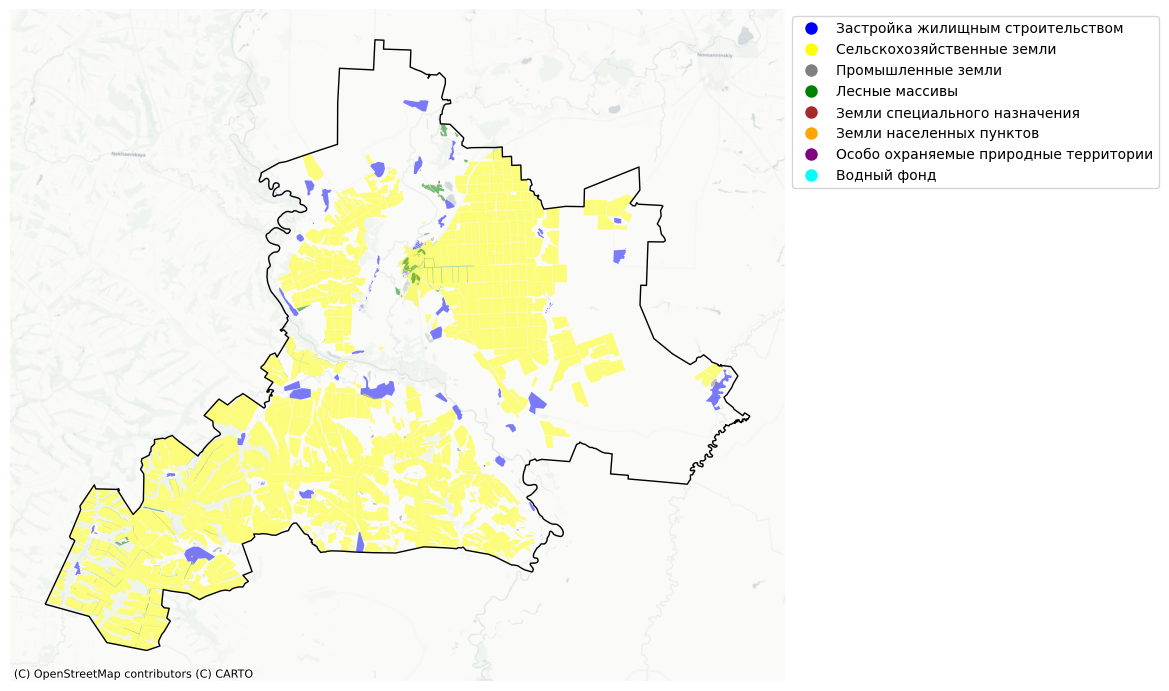

In [77]:
landuse_data = get_landuse_data(districts_gdf.geometry.iloc[0])
# urbanization_data = calculate_urbanization(districts_gdf, [landuse_data])
plot_landuse(districts_gdf, landuse_data)

In [70]:
# Выберите ключ, по которому хотите создать GeoDataFrame
key = '1.3.6 Процент земель населенных пунктов'
# key = '1.3.2 Процент земель сельскохозяйственного назначения'
# Извлеките значения (геометрии) по заданному ключу
geometries = landuse_data[key]
geometries

,geometry
0,"POLYGON ((44.12298 48.62818, 44.12336 48.62807..."
1,"POLYGON ((44.66096 48.82268, 44.66073 48.82282..."
2,"POLYGON ((44.66011 48.82359, 44.66009 48.82367..."
3,"POLYGON ((44.66008 48.82372, 44.66007 48.82378..."
4,"POLYGON ((44.66145 48.82638, 44.66149 48.82648..."
5,"POLYGON ((44.66165 48.82674, 44.66175 48.82687..."


In [7]:
districts_gdf = gpd.read_file('C:\Code\PopFrame\9 регионов\Краснодарский край\Каркас населения\district.geojson')
# districts_gdf = districts_gdf.loc[[8]].reset_index(drop=True)
result_gdf = process_districts(districts_gdf)
result_gdf.to_excel('output.xlsx', index=False)
result_gdf

Polygon bounds: (37.9876894, 44.5810163, 38.588104, 45.188832)
Error fetching data for tag filter {'landuse': 'nature_reserve'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'military'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'apartments'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'conservation'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'national_park'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'greenhouse_horticulture'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'aquaculture'}: No data elements in server response. Check log and

,№ п/п,Название хранимое,ед.изм.,Значение,Территория,Источник,Период
0,1.3.1,Процент застройки жилищным строительством,%,0.5,Абинский район,modeled,2024
1,1.3.2,Процент земель сельскохозяйственного назначения,%,34.9,Абинский район,modeled,2024
2,1.3.3,Процент земель промышленного назначения,%,0.1,Абинский район,modeled,2024
3,1.3.4,"Процент земель, занимаемыми лесными массивами",%,0.3,Абинский район,modeled,2024
4,1.3.5,Процент земель специального назначения,%,0.0,Абинский район,modeled,2024
...,...,...,...,...,...,...,...
400,1.3.5,Процент земель специального назначения,%,0.0,Щербиновский район,modeled,2024
401,1.3.6,Процент земель населенных пунктов,%,1.3,Щербиновский район,modeled,2024
402,1.3.7,"Процент земель, занимаемых особо охраняемыми п...",%,0.0,Щербиновский район,modeled,2024
403,1.3.8,"Процент земель, занимаемых водным фондом",%,0.0,Щербиновский район,modeled,2024


In [6]:
result_gdf.to_excel('output.xlsx', index=False)